# Sad TP

## Library's

In [1]:
import re
import findspark
findspark.init()
from pyspark import *
from pyspark.sql import *
from graphframes import *
import operator

In [2]:
from pyspark.sql.types import DoubleType
from IPython.display import Image

## Preprocessing

The preprocessig part is done using only python 

In [3]:
txt_file="data.txt"

In [4]:
file = open(txt_file)
clean_file=""


In [5]:
    for line in file:
        #removing empty lines and spacial caracters
        if line!="\n":
            clean_file+=re.sub('[^A-Za-z0-9\s]+', '',line)

In [6]:
clean_file.replace("\n"," ")
f = open('preprocessed-data.txt', 'w')

In [7]:
f.write(clean_file)

6246720

# Processing

### Reading file

In [8]:
words=spark.sparkContext.textFile("preprocessed-data.txt").flatMap(lambda line: line.split(" ")).filter(lambda x:x!='')
words.take(5)

['The', 'Project', 'Gutenberg', 'EBook', 'of']

### Building the table of paires

we will give for each word an id then wee will join them by their keys (the key is incremented by 2)

In [9]:
y=words.zipWithIndex().map(lambda x: ( x[1]*2,x[0]))
y.take(5)

[(0, 'The'), (2, 'Project'), (4, 'Gutenberg'), (6, 'EBook'), (8, 'of')]

In [10]:
x=y.map(lambda x: (x[0]+2, x[1]))
x.take(5)

[(2, 'The'), (4, 'Project'), (6, 'Gutenberg'), (8, 'EBook'), (10, 'of')]

In [11]:
xy=x.join(y).map(lambda x: x[1])
xy.take(3)

[('The', 'Project'), ('Project', 'Gutenberg'), ('Gutenberg', 'EBook')]

Counting the pairs frequency #(Xi,Yj) 

In [12]:
psfq=xy.map(lambda x: (x,1)).reduceByKey(operator.add)
psfq.take(3)

[(('restrictions', 'in'), 2), (('the', 'Speckled'), 1), (('the', 'Noble'), 2)]

Counting the pairs frequency of words #(Yj)

In [13]:
wsfq=words.map(lambda word: (word, 1)).reduceByKey(operator.add)
wsfq.take(3)

[('The', 7106), ('Project', 221), ('Gutenberg', 98)]

Counting the pairs relative frequency of words #(Xi,Yj) / #(Yj)

-To do this task we add the word Yj to the RDD who has the pairs frequency so we can join him with the RDD who contains the words frequency

In [14]:
psrfq=wsfq.join(psfq.map(lambda x:(x[0][1],x,x[1]))).map(lambda x:(x[1][1][0],x[1][1][1]/x[1][0]))
psrfq.take(3)

[(('phrase', 'Project'), 0.03619909502262444),
 (('Redistributing', 'Project'), 0.00904977375565611),
 (('of', 'Project'), 0.09954751131221719)]

### 1a. The 1000 most frequent pairs (Xi , Yj) sorted by:(Yj)

The number of elements to show

In [15]:
n=1000

In [16]:
psfq.sortBy(lambda x: (x[1],x[0][1]), False).toDF().show(n)

+--------------------+-----+
|                  _1|   _2|
+--------------------+-----+
|           [of, the]|12441|
|           [in, the]| 5754|
|           [to, the]| 4351|
|          [and, the]| 3076|
|           [on, the]| 2232|
|           [at, the]| 1920|
|           [by, the]| 1872|
|         [from, the]| 1759|
|             [of, a]| 1703|
|         [with, the]| 1665|
|            [to, be]| 1593|
|         [that, the]| 1347|
|           [with, a]| 1337|
|             [in, a]| 1307|
|          [for, the]| 1274|
|           [he, had]| 1246|
|          [did, not]| 1191|
|         [had, been]| 1103|
|            [it, is]| 1070|
|           [of, his]| 1067|
|           [may, be]| 1018|
|    [Prince, Andrew]|  976|
|         [the, same]|  965|
|         [into, the]|  956|
|           [it, was]|  950|
|           [he, was]|  909|
|          [that, he]|  874|
|             [as, a]|  801|
|           [to, him]|  788|
|           [as, the]|  764|
|           [in, his]|  763|
|            [

### 1b. The 1000 most frequent pairs (Xi , Yj) sorted by:#(Xi,Yj) / #(Yj)

In [17]:
psrfq.sortBy(lambda x: (x[1],x[0][1]), False).toDF().show(n)

+--------------------+---+
|                  _1| _2|
+--------------------+---+
|    [the, zygomatic]|1.0|
|   [process, zygoma]|1.0|
|   [tender, zonenot]|1.0|
|          [dat, zis]|1.0|
|          [of, zinc]|1.0|
|       [boss, zides]|1.0|
|      [dragon, zeus]|1.0|
|     [my, zeropoint]|1.0|
|        [and, zeres]|1.0|
|       [the, zenith]|1.0|
|          [and, zen]|1.0|
|       [to, zakuska]|1.0|
|    [with, youvodka]|1.0|
|       [to, youturn]|1.0|
|      [to, youthose]|1.0|
|[his, youthfulnes...|1.0|
|[shrewd, youthfully]|1.0|
|      [told, youthe]|1.0|
|[frightened, yousit]|1.0|
|       [in, yourshe]|1.0|
|[othersthe, young...|1.0|
|[splendid, youngs...|1.0|
|         [to, youis]|1.0|
|      [beg, yougive]|1.0|
|      [for, youeven]|1.0|
|    [tell, youPeter]|1.0|
|      [for, youJems]|1.0|
| [dealer, yorkshire]|1.0|
|        [blue, york]|1.0|
|[inaccessible, yore]|1.0|
|       [bridle, yon]|1.0|
|       [were, yoked]|1.0|
|[quite, yieldedwent]|1.0|
|       [beaux, yeux]|1.0|
|

### 2. The 1000 most frequent pairs of each word (Yj)

In [32]:
psrfq.map(lambda x:(x[0][1],x)).reduceByKey(max).map(lambda x:(x[1][0],x[1][1])).toDF().show(n)

+--------------------+--------------------+
|                  _1|                  _2|
+--------------------+--------------------+
|[wrnpc11atxt, Pro...|0.004524886877828055|
|          [zone, of]|3.023660140600197E-4|
|     [wherever, Sir]|0.027777777777777776|
|         [JA, Doyle]|                0.25|
|     [yourself, are]|5.644933672029354E-4|
|          [zen, all]| 2.70929287455974E-4|
|       [years, over]|7.987220447284345E-4|
|      [zonenot, the]|1.389043227025225...|
|         [you, sure]| 0.02459016393442623|
|    [the, copyright]|  0.3333333333333333|
|      [zoology, for]|1.531862745098039...|
|       [you, before]|0.003182179793158...|
|[noblest, downloa...|                 0.2|
|          [you, any]| 0.00960698689956332|
|       [the, header]|  0.2857142857142857|
|         [you, seen]| 0.01126126126126126|
|       [youth, when]|5.060728744939271E-4|
|     [when, viewing]|  0.3333333333333333|
|        [this, file]|                 0.2|
|        [youve, not]|1.55836060

## Experiments

### cluster of one machine

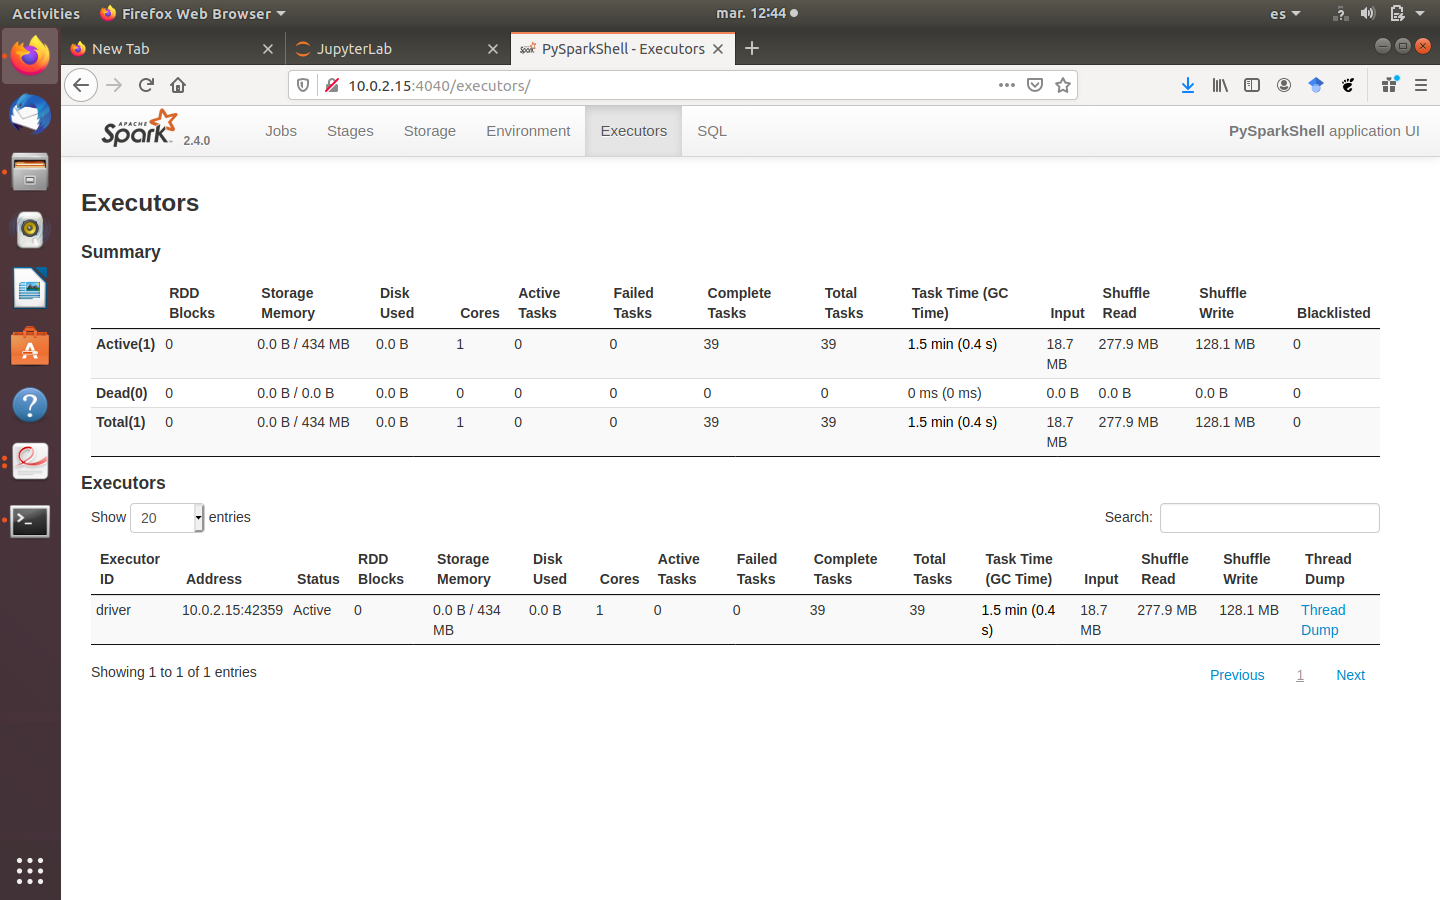

In [19]:
# configuration
Image(filename = "configuration-one-machine.png", width = 900, height = 508)

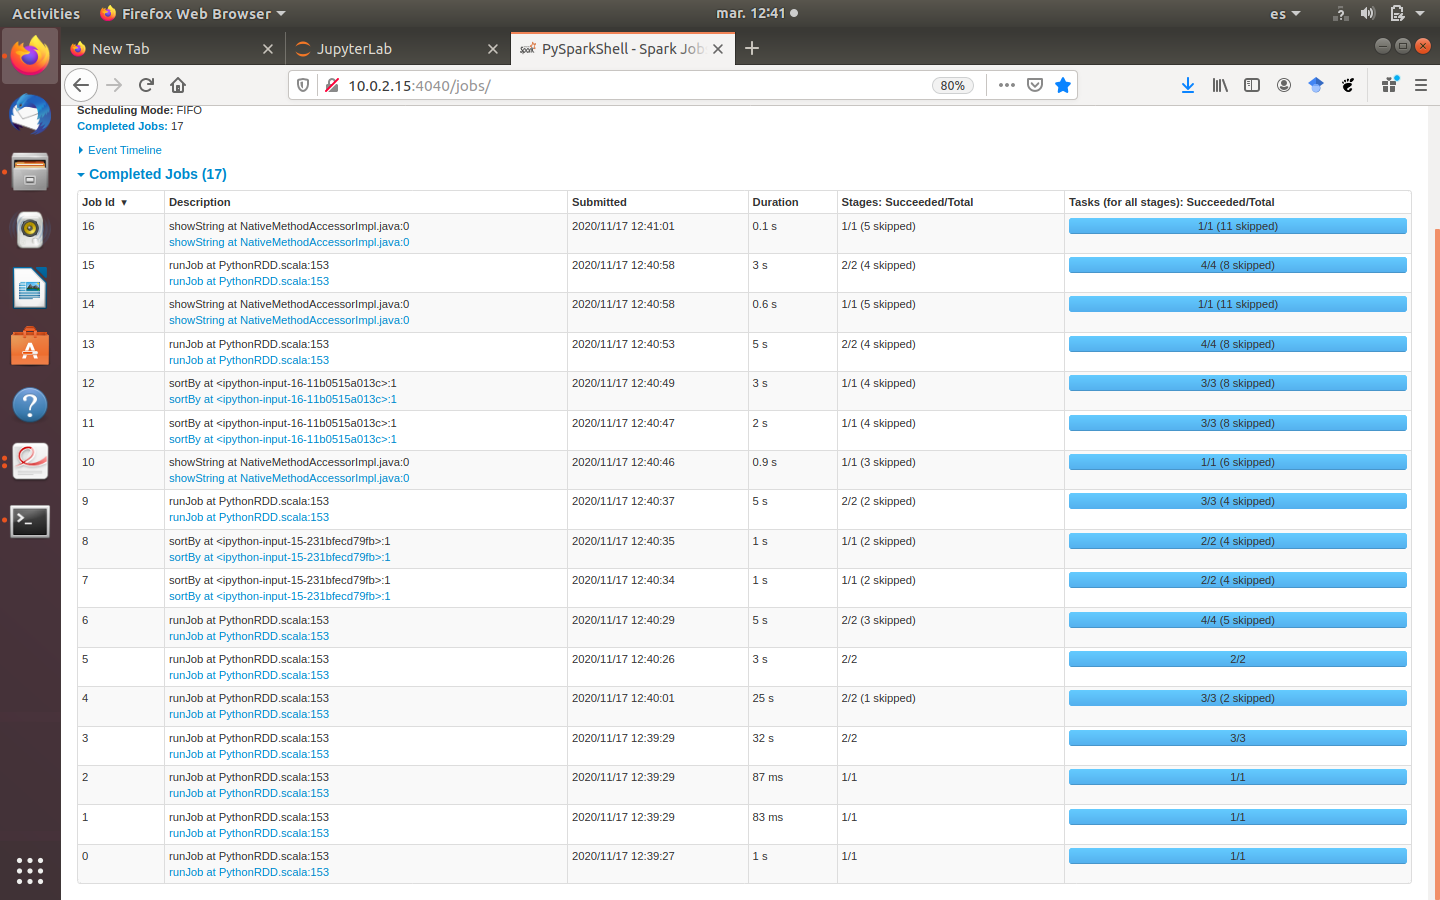

In [20]:
# performance
Image(filename = "performance-one-machine.png", width = 900, height = 508)

The execution time is 87.77 s

### cluster of three machines

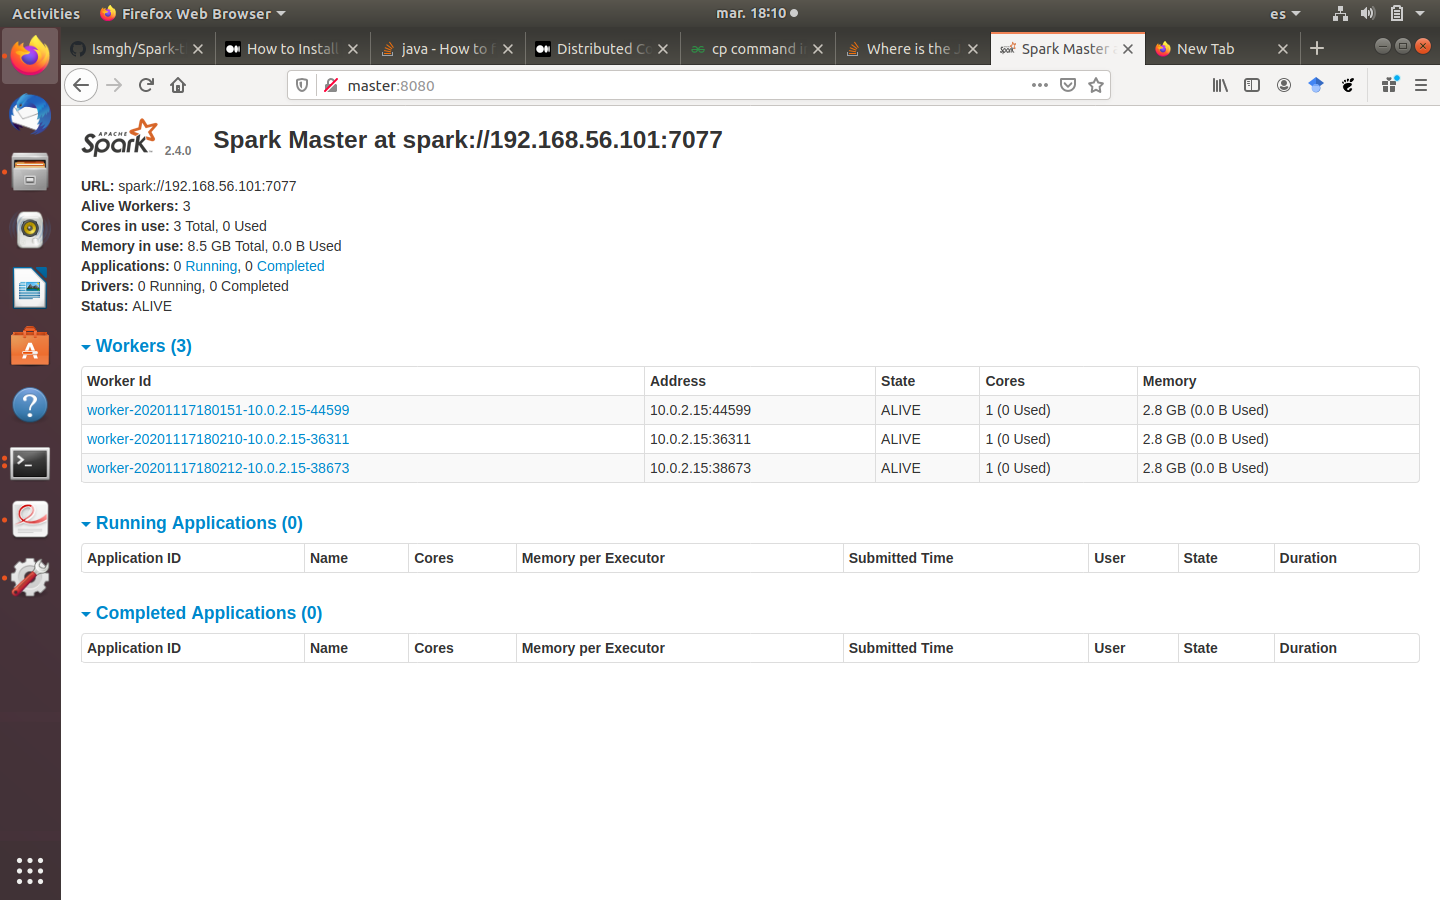

In [22]:
# configuration
Image(filename = "configuration-three-machines.png", width = 900, height = 508)

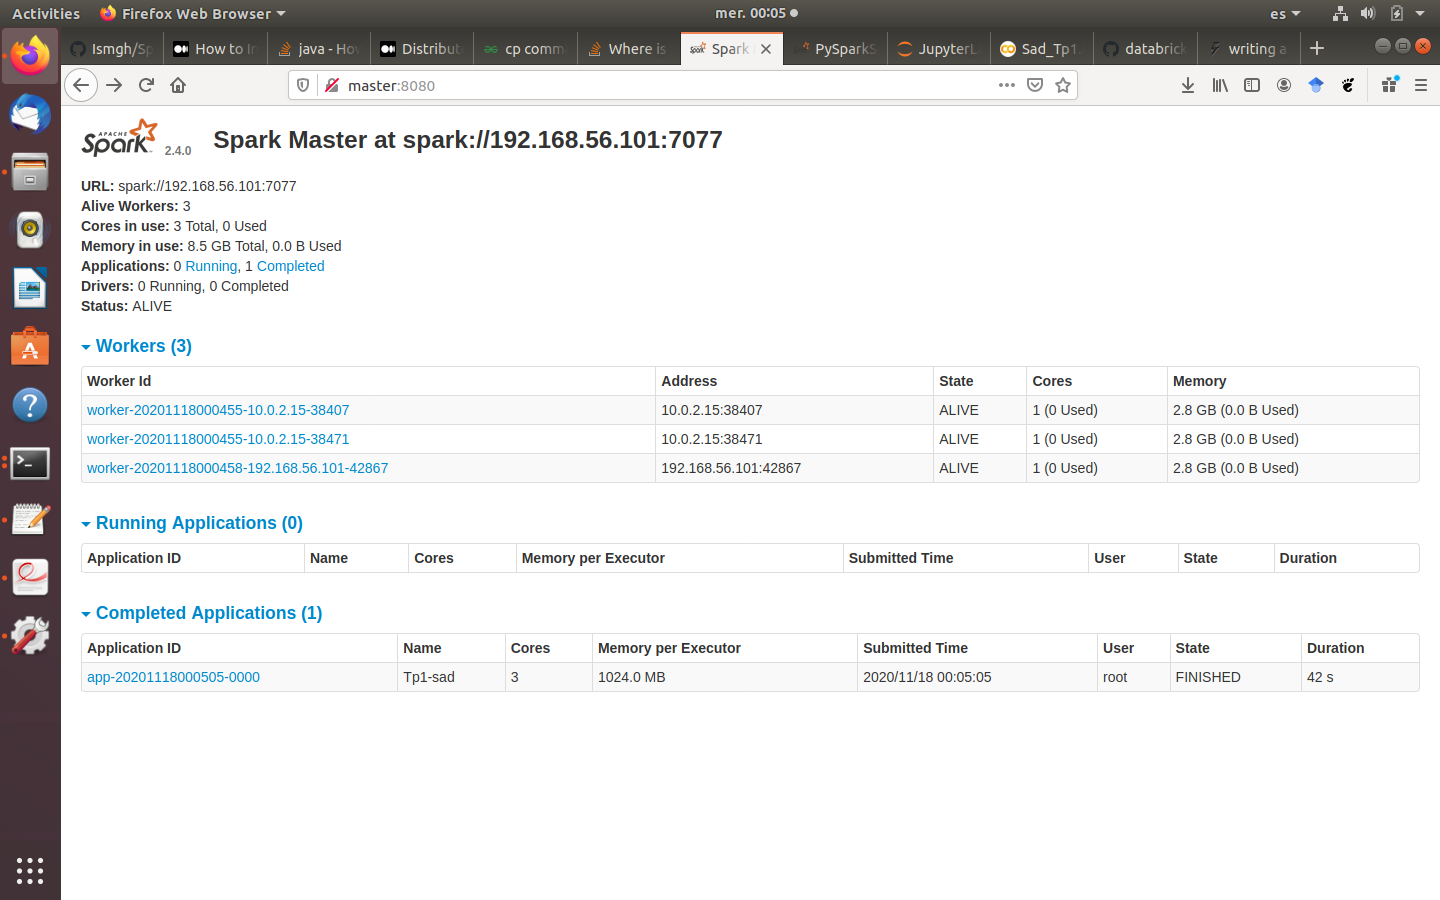

In [34]:
# performance
Image(filename = "performace-three-machines.png", width = 900, height = 508)

The execution time is 42 s

## statistics

Text(0.5, 0, 'number of machines in cluster')

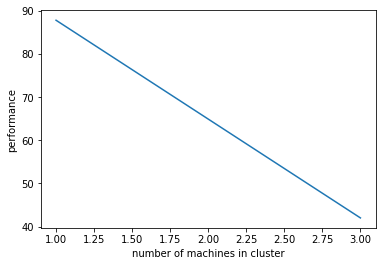

In [36]:
import matplotlib.pyplot as plt
plt.plot([1, 3], [87.77, 42])
plt.ylabel('performance')
plt.xlabel('number of machines in cluster')

## summary

The time of execution decresed by half but logicaly it should decrease by third the reason is that localy data is extchaged much faster because the memory is shared but in the cluster the data can only be transfered using messages witch is so much slower. 